# 1. Import Necessary Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# For reproducibility

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

# 2. Configuration 

In [77]:
N_ROWS_TO_LOAD = 100000
CSV_FILE_PATH = "brewery_data_complete_extended.csv"

# Specific parameters

In [80]:
FEATURE_COLUMNS = ['Gravity', 'Alcohol_Content', 'pH_Level', 'Moisture_Content', 'Temperature']
BRIX_COLUMN = 'Gravity'         # Using Gravity as a proxy for Brix
ALCOHOL_COLUMN = 'Alcohol_Content'
PH_COLUMN = 'pH_Level'
MOISTURE_COLUMN = 'Moisture_Content' # This will be simulated
TEMP_COLUMN = 'Temperature'
TARGET_COLUMN = 'Fermentation_Status' # This will be simulated (0: Not Ready, 1: Ready)

# Model Hyperparameters (initial suggestions, tune these!)

In [83]:
EPOCHS = 50 # Might be too high without good early stopping for large data
BATCH_SIZE = 64
LEARNING_RATE = 0.001
L2_REG = 0.001 # L2 regularization factor
DROPOUT_RATE = 0.3
LSTM_UNITS = 64
DENSE_UNITS_MLP = [128, 64, 32] # Neurons in MLP hidden layers
DENSE_UNITS_LSTM_POST = [64, 32] # Neurons in Dense layers after LSTM

# 3. Load and Preprocess Data 

## 3.1 Load Data 

In [87]:
try:
    df = pd.read_csv("preprocessed_brewery_data.csv") # Or .pkl
    print(f"Successfully loaded preprocessed data.")
    # Ensure FEATURE_COLUMNS and TARGET_COLUMN are present in this preprocessed file
    if not all(col in df.columns for col in FEATURE_COLUMNS + [TARGET_COLUMN]):
        raise ValueError("Preprocessed data does not contain all required feature/target columns.")
except FileNotFoundError:
    print("ERROR: Preprocessed data file not found. Cannot proceed with modeling.")
    # Exit or raise an error, as dummy data creation won't make sense here
    raise

Successfully loaded preprocessed data.


## 3.5 IQR Outlier Capping for Features

In [90]:
print("\nApplying IQR outlier capping...")
for col in FEATURE_COLUMNS:
    if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
print("IQR outlier capping complete.")


Applying IQR outlier capping...
IQR outlier capping complete.


## 3.6 Prepare Features (X) and Target (y)

In [93]:
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

In [95]:
print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")
print(f"NaNs in X after all preprocessing: {X.isnull().sum().sum()}")
print(f"NaNs in y after all preprocessing: {y.isnull().sum().sum()}")


Shape of X: (100000, 5), Shape of y: (100000,)
NaNs in X after all preprocessing: 0
NaNs in y after all preprocessing: 0


## 3.7 Data Splitting (Train, Validation, Test) 

In [98]:
# First split: 80% for training+validation, 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Second split: From the 80%, split into 75% training, 25% validation (makes 60% train, 20% val of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val # 0.25 * 0.8 = 0.2
)

print(f"Training set: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Validation set: X_val shape {X_val.shape}, y_val shape {y_val.shape}")
print(f"Test set: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

Training set: X_train shape (60000, 5), y_train shape (60000,)
Validation set: X_val shape (20000, 5), y_val shape (20000,)
Test set: X_test shape (20000, 5), y_test shape (20000,)


## 3.8 Feature Scaling (Standardization)

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling complete.")


Feature scaling complete.


# 4. Model Definitions

## 4.1 MLP (ANN / DNN) Model

In [120]:
def create_mlp_model(input_shape, dense_units, dropout_rate, l2_reg):
    model = Sequential(name="MLP_Model")
    model.add(Input(shape=input_shape)) # Explicit Input layer

    for units in dense_units:
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid')) # Output layer for binary classification

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

##  4.2 LSTM (RNN / DNN) Model 

In [123]:
def create_lstm_model(input_shape_rnn, lstm_units, dense_units_post, dropout_rate, l2_reg):
    """
    input_shape_rnn: (timesteps, features)
    """
    model = Sequential(name="LSTM_Model")
    model.add(Input(shape=input_shape_rnn)) # Explicit Input layer for RNN

    # LSTM Layer
    # If stacking LSTMs, set return_sequences=True for all but the last LSTM layer
    model.add(LSTM(lstm_units, kernel_regularizer=l2(l2_reg))) # Last LSTM returns single vector
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Dense layers after LSTM
    for units in dense_units_post:
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid')) # Output layer

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# 5. Training Procedure 

In [126]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# model_checkpoint_mlp = ModelCheckpoint('best_mlp_model.keras', save_best_only=True, monitor='val_loss')
# model_checkpoint_lstm = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')
# Using .weights.h5 for simplicity with ModelCheckpoint when also using EarlyStopping's restore_best_weights
model_checkpoint_mlp = ModelCheckpoint('best_mlp_model.weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)
model_checkpoint_lstm = ModelCheckpoint('best_lstm_model.weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)


## 5.1 Train MLP Model 

In [129]:
print("\n--- Training MLP Model ---")
mlp_input_shape = (X_train_scaled.shape[1],)
mlp_model = create_mlp_model(mlp_input_shape, DENSE_UNITS_MLP, DROPOUT_RATE, L2_REG)
mlp_model.summary()

history_mlp = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint_mlp],
    verbose=1
)
# Load the best weights saved by ModelCheckpoint if EarlyStopping restored them
mlp_model.load_weights('best_mlp_model.weights.h5')


--- Training MLP Model ---


Model: "MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 11,585 (45.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8557 - auc: 0.9307 - loss: 0.4732 - val_accuracy: 0.9895 - val_auc: 0.9996 - val_loss: 0.1147
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9812 - auc: 0.9946 - loss: 0.1263 - val_accuracy: 0.9915 - val_auc: 0.9996 - val_loss: 0.0673
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9863 - auc: 0.9967 - loss: 0.0780 - val_accuracy: 0.9930 - val_auc: 0.9998 - val_loss: 0.0442
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9887 - auc: 0.9978 - loss: 0.0558 - val_accuracy: 0.9937 - val_auc: 0.9998 - val_loss: 0.0334
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9900 - auc: 0.9981 - loss: 0.0460 - val_accuracy: 0.9958 - val_auc: 0.9998 - val_loss: 0.0265
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9907 - auc: 0.9981 - loss: 0.0406 - val_accuracy: 0.9951 - val_auc: 0.9999 - val_loss: 0.0235
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 

## 5.2 Prepare Data and Train LSTM Model

In [133]:
print("\n--- Training LSTM Model ---")
# Reshape data for LSTM: (samples, timesteps, features)
# For this demo, we treat each sample as a sequence of 1 timestep.
# In a real scenario with sensor data over time per batch, timesteps would be > 1.
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"Reshaped data for LSTM: X_train_rnn shape {X_train_rnn.shape}")

lstm_input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2]) # (timesteps, features)
lstm_model = create_lstm_model(lstm_input_shape, LSTM_UNITS, DENSE_UNITS_LSTM_POST, DROPOUT_RATE, L2_REG)
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train_rnn, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_rnn, y_val),
    callbacks=[early_stopping, model_checkpoint_lstm],
    verbose=1
)
# Load the best weights
lstm_model.load_weights('best_lstm_model.weights.h5')


--- Training LSTM Model ---
Reshaped data for LSTM: X_train_rnn shape (60000, 1, 5)


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 24,513 (95.75 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8469 - auc: 0.9147 - loss: 0.4707 - val_accuracy: 0.9900 - val_auc: 0.9993 - val_loss: 0.1084
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9714 - auc: 0.9908 - loss: 0.1386 - val_accuracy: 0.9909 - val_auc: 0.9996 - val_loss: 0.0696
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9766 - auc: 0.9938 - loss: 0.0953 - val_accuracy: 0.9868 - val_auc: 0.9997 - val_loss: 0.0556
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9796 - auc: 0.9952 - loss: 0.0754 - val_accuracy: 0.9909 - val_auc: 0.9997 - val_loss: 0.0428
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9821 - auc: 0.9950 - loss: 0.0656 - val_accuracy: 0.9924 - val_auc: 0.9998 - val_loss: 0.0375
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9828 - auc: 0.9959 - loss: 0.0599 - val_accuracy: 0.9923 - val_auc: 0.9998 - val_loss: 0.0354
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 

# 6. Evaluation Procedure (Validation and Testing) 


--- Evaluating MLP (ANN/DNN) Model ---


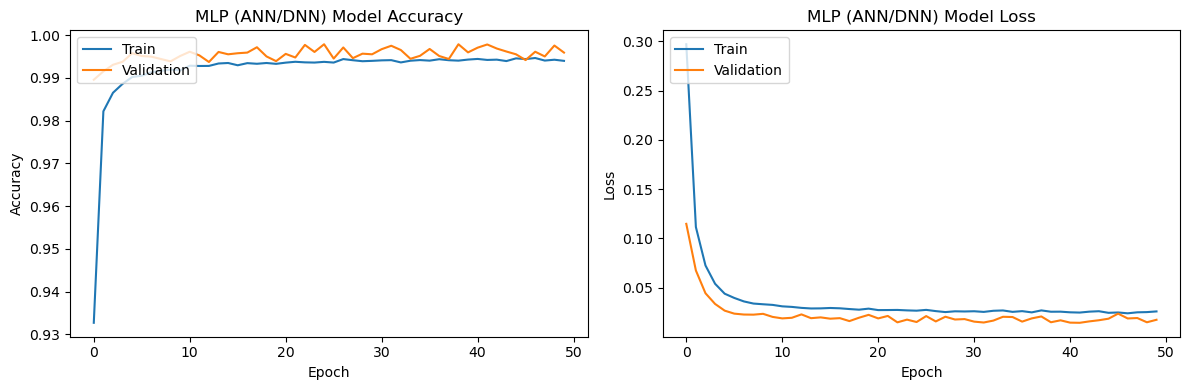

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step

MLP (ANN/DNN) Test Set Performance:
Accuracy: 0.9978
Precision: 0.9853
Recall: 0.9926
F1-score: 0.9890
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17969
           1       0.99      0.99      0.99      2031

    accuracy                           1.00     20000
   macro avg       0.99      1.00      0.99     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix:


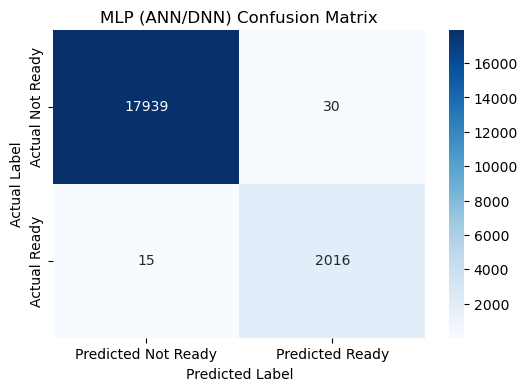

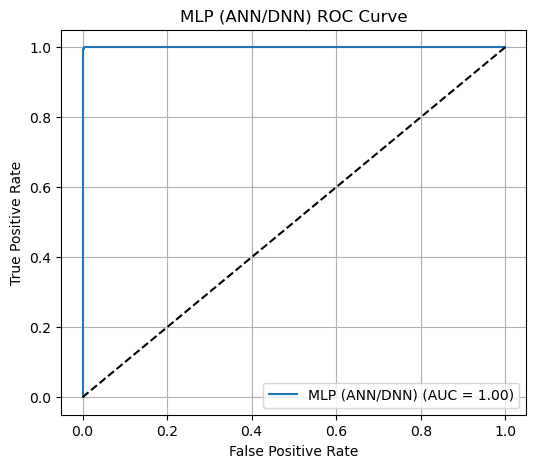


--- Evaluating LSTM (RNN/DNN) Model ---


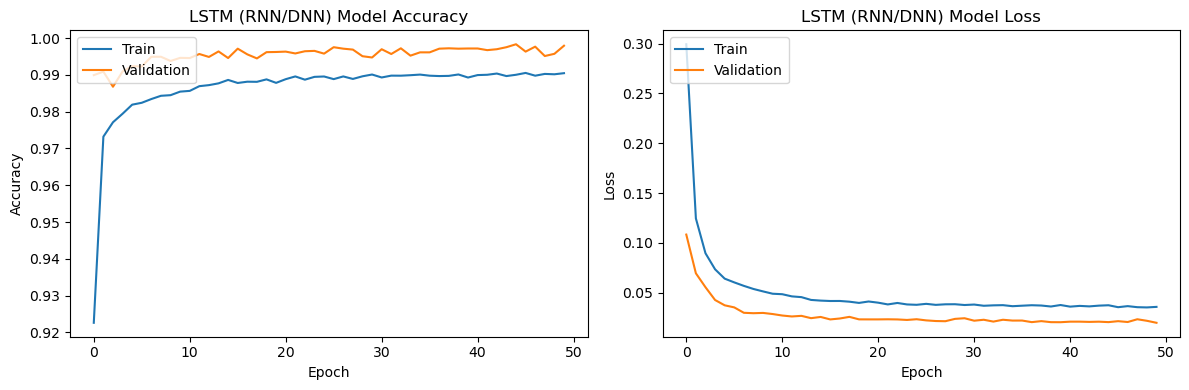

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step

LSTM (RNN/DNN) Test Set Performance:
Accuracy: 0.9979
Precision: 0.9935
Recall: 0.9852
F1-score: 0.9894
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17969
           1       0.99      0.99      0.99      2031

    accuracy                           1.00     20000
   macro avg       1.00      0.99      0.99     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix:


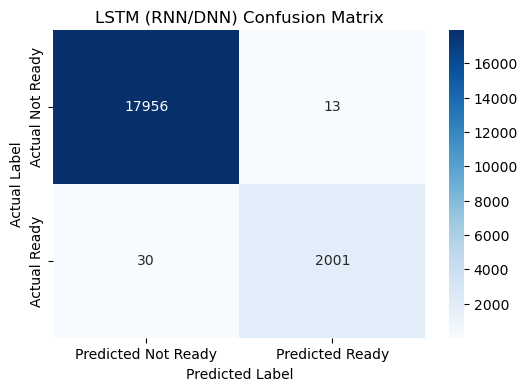

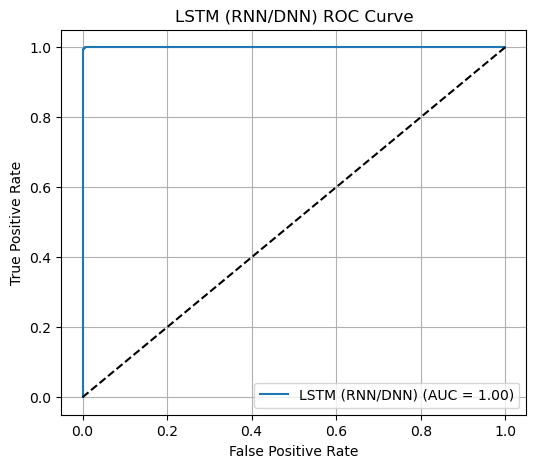

In [135]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def evaluate_model_performance(model, X_test_data, y_test_data, history, model_name, is_rnn=False):
    print(f"\n--- Evaluating {model_name} Model ---")

    # Plot training history (includes validation performance over epochs)
    plot_training_history(history, model_name)

    # Predictions on the Test Set
    y_pred_proba = model.predict(X_test_data).ravel() # Ravel for consistency
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    # --- Testing Procedure Metrics ---
    accuracy = accuracy_score(y_test_data, y_pred_classes)
    precision = precision_score(y_test_data, y_pred_classes, zero_division=0)
    recall = recall_score(y_test_data, y_pred_classes, zero_division=0)
    f1 = f1_score(y_test_data, y_pred_classes, zero_division=0)
    auc = roc_auc_score(y_test_data, y_pred_proba)

    print(f"\n{model_name} Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_data, y_pred_classes, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data, y_pred_classes)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Not Ready', 'Predicted Ready'],
                yticklabels=['Actual Not Ready', 'Actual Ready'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC Curve
    plot_roc_curve(y_test_data, y_pred_proba, model_name)
    
    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}

# Evaluate MLP Model
mlp_results = evaluate_model_performance(mlp_model, X_test_scaled, y_test, history_mlp, "MLP (ANN/DNN)")

# Evaluate LSTM Model
# Note: The LSTM model was trained on data with timesteps=1.
# This means it operates similarly to an MLP for this specific data structure,
# but the architecture is different and could leverage true sequences if available.
lstm_results = evaluate_model_performance(lstm_model, X_test_rnn, y_test, history_lstm, "LSTM (RNN/DNN)", is_rnn=True)


# 7. Quality Requirements and Evaluation of Results (Summary)

In [137]:
print("\n--- Summary of Model Performance on Test Set ---")
results_df = pd.DataFrame([mlp_results, lstm_results])
print(results_df)

print("\nDiscussion of Quality Requirements Met:")
# Example discussion points (refer to your defined targets)
for index, row in results_df.iterrows():
    print(f"\nFor {row['Model']}:")
    print(f"  Accuracy ({row['Accuracy']:.4f}): Compare against your target (e.g., >0.85-0.90)")
    print(f"  Precision ({row['Precision']:.4f}): Compare against your target (e.g., >0.85-0.90)")
    print(f"  Recall ({row['Recall']:.4f}): Compare against your target (e.g., >0.85-0.90)")
    print(f"  F1-Score ({row['F1']:.4f}): Compare against your target (e.g., >0.85-0.90)")
    print(f"  AUC ({row['AUC']:.4f}): Compare against your target (e.g., >0.90)")

print("\nFurther Considerations:")
print("- The target variable was SIMULATED. Real-world performance depends on accurate ground truth labeling.")
print("- The LSTM model was demonstrated with timesteps=1 due to data structure. With true sequential sensor data per batch, its ability to capture temporal patterns would be more rigorously tested.")
print("- Hyperparameter tuning is essential for optimizing these models further.")
print("- The visual analytics dashboard aspect would be the next step for presenting these model outputs.")


--- Summary of Model Performance on Test Set ---
            Model  Accuracy  Precision    Recall        F1       AUC
0   MLP (ANN/DNN)   0.99775   0.985337  0.992614  0.988962  0.999956
1  LSTM (RNN/DNN)   0.99785   0.993545  0.985229  0.989370  0.999961

Discussion of Quality Requirements Met:

For MLP (ANN/DNN):
  Accuracy (0.9978): Compare against your target (e.g., >0.85-0.90)
  Precision (0.9853): Compare against your target (e.g., >0.85-0.90)
  Recall (0.9926): Compare against your target (e.g., >0.85-0.90)
  F1-Score (0.9890): Compare against your target (e.g., >0.85-0.90)
  AUC (1.0000): Compare against your target (e.g., >0.90)

For LSTM (RNN/DNN):
  Accuracy (0.9979): Compare against your target (e.g., >0.85-0.90)
  Precision (0.9935): Compare against your target (e.g., >0.85-0.90)
  Recall (0.9852): Compare against your target (e.g., >0.85-0.90)
  F1-Score (0.9894): Compare against your target (e.g., >0.85-0.90)
  AUC (1.0000): Compare against your target (e.g., >0.90)

Fu